# Debiasing Notebook

This notebook takes in binned and cleaned Galaxy Zoo data and produces a debiased output catalogue. This notebook is based on the procedure outlined in [Hart et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.461.3663H/abstract), and original debiasing efforts hosted on the GAMA branch of [this GitHub repo](https://github.com/RossHart/Debiasing/tree/GAMA).

In [1]:
#--------------------------------68-------------------------------->

In [2]:
# imports
import os
import sys
import warnings
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import (
    AnchoredSizeBar as scalebar
)
from collections import Counter as counter
import scipy.stats as st
from scipy.ndimage import gaussian_filter as gauss
import copy
import astropy.stats as stats
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
import pandas as pd
import imageio
import time

# Notebook startup
%config InlineBackend.print_figure_kwargs={'facecolor':"w"}
print(f'Notebook run time: \n   {time.ctime()}')
#--------------------------------68-------------------------------->

Notebook run time: 
   Wed Jun 24 15:59:04 2020


## Data Read, Analysis and Setup

In [3]:
# z to dist
def z_to_dist(z):
    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    return cosmo.luminosity_distance(z)

In [4]:
# mag to Mag
def mag_to_Mag(mag, z):
    import astropy.units as u
    D = z_to_dist(z)
    Mag = mag - 5*(np.log10(D/(u.pc))-1)
    return Mag

In [5]:
# gama tabular data
gama_cln = Table.read('../gz_gama_2018-02-25_cleaned.fits.gz')
gama_bin = Table.read('../gz_gama_2018-02-25_binned.fits.gz')
gama_ext = Table.read('../../inputs/manifest/gamazoo_extra.fits.gz')

In [6]:
# add original binned total counts to cleaned catalogue
N_names = [c for c in gama_bin.colnames if 'total' in c]
for n in N_names:
    gama_cln[n + '_bin'] = gama_bin[n]

In [7]:
# GAMA R50 (kpc) and Mr (absmag) quality cuts
R50lo = 0.4
R50hi = 25
Mrlo = -23
Mrhi = -15

In [8]:
# generate primary data table
R50 = gama_ext['GALRE_r_kpc']
Mr = gama_ext['absmag_r']

R_ok = np.all([R50 > R50lo, R50 < R50hi], axis=0)
Mr_ok = np.all([Mr > Mrlo, Mr < Mrhi], axis=0)
data_ok = (R_ok) & (Mr_ok)

print(f' R50_ok: {sum(R_ok)} / {len(R_ok)} ({sum(~R_ok)})')
print(f'  Mr_ok: {sum(Mr_ok)} / {len(Mr_ok)} ({sum(~Mr_ok)})')
print(f'data_ok: {sum(data_ok)} / {len(data_ok)} ({sum(~data_ok)})')

data = gama_cln[data_ok]
for c in ('absmag_r', 'GALRE_r_kpc', 'Z_TONRY'):
    data[c] = gama_ext[data_ok][c] 

 R50_ok: 49213 / 49866 (653)
  Mr_ok: 49425 / 49866 (441)
data_ok: 48871 / 49866 (995)


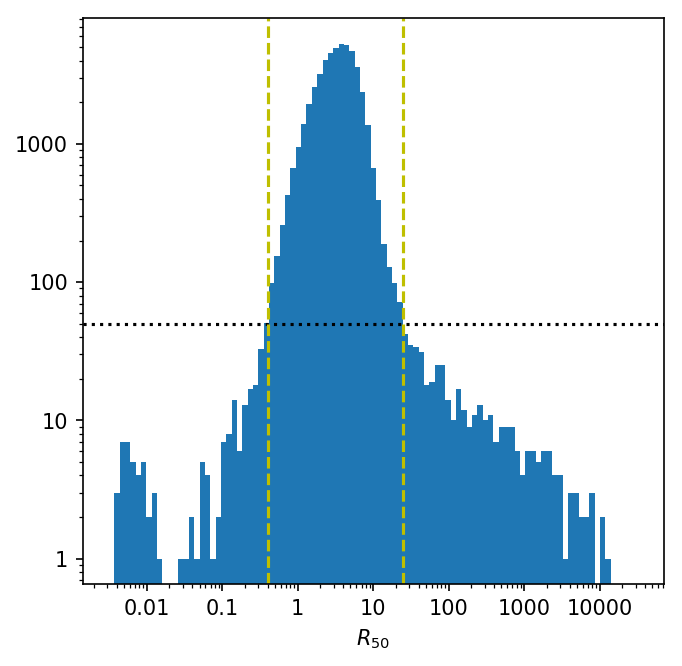

In [9]:
# R50 analysis plot
fig = plt.figure(figsize=(5,5), dpi=150)
ax = plt.subplot(111)

ax.hist(R50, bins=np.logspace(-2.5, 4.5, 100))
ax.loglog()
fmt = matplotlib.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y))
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
plt.axhline(50, c='k', ls='dotted')
plt.axvline(R50lo, c='y', ls='--')
plt.axvline(R50hi, c='y', ls='--')
ax.set_xlabel('$R_{50}$')

plt.show()
plt.close()

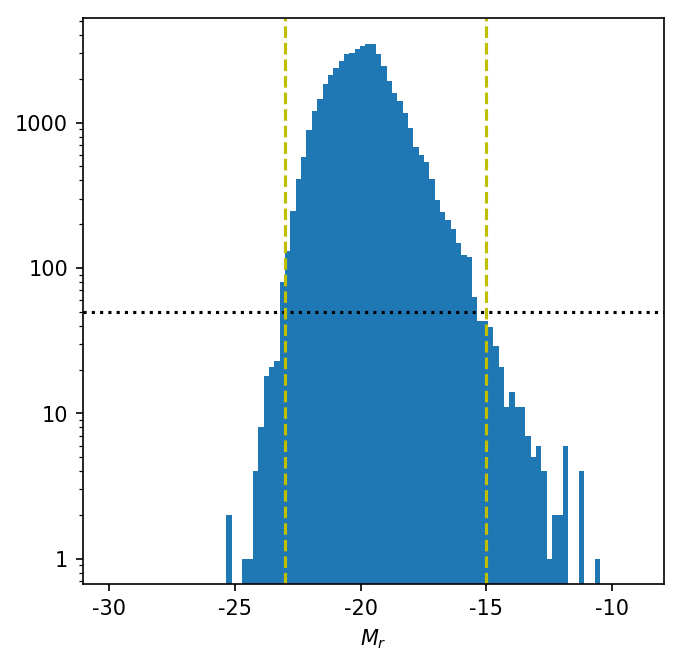

In [10]:
# Mr analysis plot
fig = plt.figure(figsize=(5,5), dpi=150)
ax = plt.subplot(111)

ax.hist(Mr, bins=np.linspace(-30,-9,100), log=True)
fmt = matplotlib.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y))
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
plt.axhline(50, c='k', ls='dotted')
plt.axvline(Mrlo, c='y', ls='--')
plt.axvline(Mrhi, c='y', ls='--')
ax.set_xlabel('$M_r$')

plt.show()
plt.close()

In [11]:
def kde2d(x, y, 
          xmin=None, xmax=None, xstep=50j, xlog=False,
          ymin=None, ymax=None, ystep=50j, ylog=False,
          levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]):
    import numpy as np
    import scipy.stats as st
    old = np.seterr(invalid='ignore')
    xmin = np.nanmin(x) if xmin is None else xmin
    xmax = np.nanmax(x) if xmax is None else xmax
    ymin = np.nanmin(y) if ymin is None else ymin
    ymax = np.nanmax(y) if ymax is None else ymax
    if xlog:
        x = np.log10(x)
        xmin = np.log10(xmin)
        xmax = np.log10(xmax)
    if ylog:
        y = np.log10(y)
        ymin = np.log10(ymin)
        ymax = np.log10(ymax)
    good = ~(np.isnan(x) | np.isnan(y))
    x = x[good]
    y = y[good]
    X, Y = np.mgrid[xmin:xmax:xstep, ymin:ymax:ystep]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    if xlog:
        X = 10**X
    if ylog:
        Y = 10**Y
    if len(levels) > 0:
        V = sorted(Z.flatten())
        C = np.cumsum(V)
        L = []
        for lvl in levels:
            idx = np.abs(C - (C[-1]*lvl)).argmin()
            L.append(V[idx])
    else:
        L = None
    np.seterr(**old)
    return X, Y, Z, L

In [12]:
# generate kernel density estimates
X, Y, Z, L = kde2d(R50, Mr, 
                   xmin=0.15, xmax=70, xlog=True, xstep=50j,
                   ymin=-13, ymax=-25, ystep=50j,
                   levels=np.arange(0.1,1,0.1))

48871/49866 have reasonable sizes and brightnesses


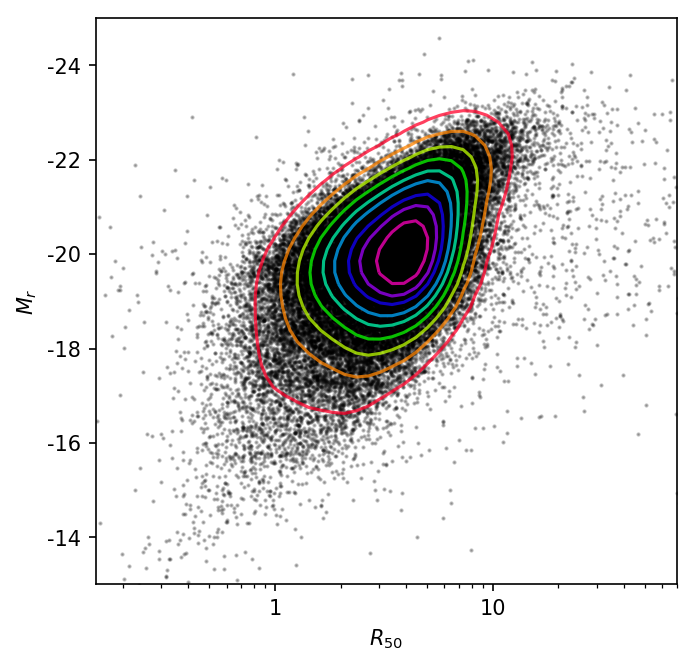

In [13]:
# GAMA R50/Mr analysis plot

print(f'{data_ok.sum()}/{len(data_ok)} have reasonable sizes and '
      f'brightnesses')

fig = plt.figure(figsize=(5,5), dpi=150)
ax = plt.subplot(111)

ax.scatter(R50, Mr, color='k', s=1, alpha=0.25)
ax.contour(X, Y, Z, levels=L, cmap='gist_rainbow', alpha=0.75)
ax.set_xscale('log')
ax.set_xlim(0.15, 70)
ax.set_ylim(-13, -25)
fmt = matplotlib.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y))
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.set_xlabel('$R_{50}$')
ax.set_ylabel('$M_r$')

plt.show()
plt.close()

M_r (limit) = -19.46597275573048


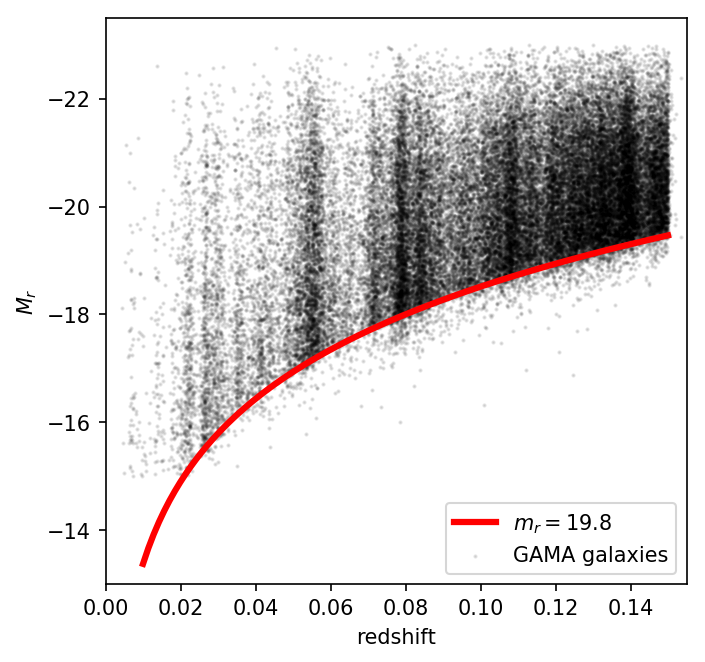

In [14]:
# primary data redshift-magnitude diagram
zs = np.linspace(0.01, 0.15, 100)
Mags = mag_to_Mag(19.8, zs)
Mag_limit = mag_to_Mag(19.8, 0.15)
print(f'M_r (limit) = {Mag_limit}')

fig = plt.figure(figsize=(5,5), dpi=150)
ax = plt.subplot(111)

plt.scatter(data['Z_TONRY'], data['absmag_r'], 
            color='k', s=1, label='GAMA galaxies', alpha=0.1)
plt.plot(zs, Mags, color='r', label='$m_r=19.8$', lw=3)
plt.xlabel('redshift')
plt.ylabel('$M_r$')
plt.legend(loc='lower right')

plt.axis((0, 0.155, -13, -23.5))

plt.show()
plt.close()

## Dictionary Question / Answer Construction

In [15]:
# params
# data_file = 'GAMA_fits/gama_to_debias.fits'
output_directory = 'output_files/'
if os.path.isdir(output_directory) is False:
    os.mkdir(output_directory)

# logistic_bounds = ((0.5,10), (-10, 10))
# exponential_bounds = ((10**(-5),10),(10**(-5),10)) 

# log_fv_range = (-1.5,0.01)
# count_suffix = '_total_raw'
# fraction_suffix = '_frac'

# Mr_column = 'absmag_r'
# R50_column = 'GALRE_r_kpc'
# z_column = 'Z_TONRY'

# n_voronoi = 30
# n_per_z = 50
# low_signal_limit = 100
# clip_percentile = 5 

# volume_redshift_limits = (0.03,0.10)
# survey_mag_limit = 19.8

In [16]:
# List of questions in order :
q = ['features',       # 0: smooth or features
     'edgeon',         # 1: edge on
     'bar',            # 2: bar
     'spiral',         # 3: spiral
     'bulge',          # 4: bulge prominence
     'round',          # 5: roundedness
     'bulgeshape',     # 6: bulge shape
     'spiralwinding',  # 7: arm winding
     'spiralnumber']   # 8: arm number

In [17]:
# 'Previously answered questions' for each question in turn:
pre_q = [None,     # 0
         [0],      # 1
         [0,1],    # 2
         [0,1],    # 3
         [0,1],    # 4
         [0,1],    # 5
         [0,1],    # 6
         [0,1,3],  # 7
         [0,1,3]]  # 8

In [18]:
# Answers for each of the questions in turn:
a = [['smooth','features','star_or_artifact'],          # 0
     ['yes','no'],                                      # 1
     ['bar','no_bar'],                                  # 2
     ['spiral','no_spiral'],                            # 3
     ['no_bulge','obvious','dominant'],                 # 4
     ['completely_round','in_between','cigar_shaped'],  # 5
     ['rounded','boxy','no_bulge'],                     # 6
     ['tight','medium','loose'],                        # 7
     ['1','2','3','4','more_than_4']]                   # 8

In [19]:
# Required answers for each previously answered question:
pre_a = [None,     # 0
         [1],      # 1
         [1,1],    # 2
         [1,1],    # 3
         [1,1],    # 4
         [1,1],    # 5
         [1,1],    # 6
         [1,1,0],  # 7
         [1,1,0]]  # 8

In [20]:
# Put all of this together in a single dictionary called "questions"
questions = dict()

for s in range(len(q)):
    
    if pre_q[s] is not None:
        pq = [q[v] for v in pre_q[s]] 
    else:
        pq = None
    
    questions[q[s]] = {'answers': a[s]
                       ,'answerlabels': a[s]
                       ,'questionlabel': q[s]
                       ,'pre_questions': pq}
    
    if pre_a[s] is not None:
        pa_array = [questions[q[v]]['answers'] 
                    for v in pre_q[s]]
        answer_arrays = [pa_array[v] 
                         for v in range(len(pre_a[s]))]
        answer_indices = [pre_a[s][v] 
                          for v in range(len(pre_a[s]))]
        pa = [answer_arrays[v2][answer_indices[v2]] 
              for v2 in range(len(answer_indices))]
 
    else:
        pa = None # if there are no previous questions
    
    questions[q[s]].update({'pre_answers': pa})

In [21]:
questions['spiralwinding']

{'answers': ['tight', 'medium', 'loose'],
 'answerlabels': ['tight', 'medium', 'loose'],
 'questionlabel': 'spiralwinding',
 'pre_questions': ['features', 'edgeon', 'spiral'],
 'pre_answers': ['features', 'no', 'spiral']}

In [22]:
#--------------------------------68-------------------------------->